# Create the Unlabeled Dataset

In [1]:
import ruptures as rpt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle

from tensorflow.keras.utils import to_categorical
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Conv2D, Flatten, Reshape, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model


In [2]:
import data_processing
import feature_extraction

In [3]:
df = data_processing.read_all_users('geolife_trajectories')
df = data_processing.process_classes(df)

[1/182] processing user 135
[2/182] processing user 132
[3/182] processing user 104
[4/182] processing user 103
[5/182] processing user 168
[6/182] processing user 157
[7/182] processing user 150
[8/182] processing user 159
[9/182] processing user 166
[10/182] processing user 161
[11/182] processing user 102
[12/182] processing user 105
[13/182] processing user 133
[14/182] processing user 134
[15/182] processing user 160
[16/182] processing user 158
[17/182] processing user 167
[18/182] processing user 151
[19/182] processing user 169
[20/182] processing user 156
[21/182] processing user 024
[22/182] processing user 023
[23/182] processing user 015
[24/182] processing user 012
[25/182] processing user 079
[26/182] processing user 046
[27/182] processing user 041
[28/182] processing user 048
[29/182] processing user 077
[30/182] processing user 083
[31/182] processing user 084
[32/182] processing user 070
[33/182] processing user 013
[34/182] processing user 014
[35/182] processing use

Extract the unllabelled data

In [4]:
unlabelled_df = data_processing.get_unlabelled(df)

In [ ]:
unlabelled_df

lat         lon         alt  elapsed time                time  \
0   39.974294  116.399741  492.000000  39816.056644 2009-01-03 01:21:34   
1   39.974292  116.399592  492.000000  39816.056655 2009-01-03 01:21:35   
2   39.974309  116.399523  492.000000  39816.056667 2009-01-03 01:21:36   
3   39.974320  116.399588  492.000000  39816.056690 2009-01-03 01:21:38   
4   39.974365  116.399730  491.000000  39816.056701 2009-01-03 01:21:39   
..        ...         ...         ...           ...                 ...   
28  39.973817  116.324117  265.748031  39286.418252 2007-07-23 10:02:17   
29  39.973333  116.323683  265.748031  39286.419028 2007-07-23 10:03:24   
30  39.973733  116.323250  364.173228  39286.419421 2007-07-23 10:03:58   
31  39.973317  116.322967  246.062992  39286.420243 2007-07-23 10:05:09   
32  39.973150  116.323283  291.994751  39286.421273 2007-07-23 10:06:38   

            trajectory label  user  
0   20090103012134.plt     0   135  
1   20090103012134.plt     0   135  
2   20090103012134.plt     0   135  
3   20090103012134.plt     0   135  
4   20090103012134.plt     0   135  
..                 ...   ...   ...  
28  20070723033153.plt     0   171  
29  20070723033153.plt     0   171  
30  20070723033153.plt     0   171  
31  20070723033153.plt     0   171  
32  20070723033153.plt     0   171  

[19449861 rows x 8 columns]

In [5]:
unlabelled_df.value_counts('label')

label
0    19449861
Name: count, dtype: int64

In [6]:
df['label'].value_counts()

label
0        19449861
walk      1585401
bus       1276632
bike       948061
train      847147
car        754825
Name: count, dtype: int64

In [7]:
df.groupby('label')['trajectory'].nunique()

label
0        17431
bike      1056
bus       1321
car       1082
train      629
walk      2299
Name: trajectory, dtype: int64

In [ ]:
df.groupby('label')['segment'].nunique()

label
0        16496
bike      1558
bus       1867
car       1340
train      758
walk      4002
Name: segment, dtype: int64

## Predicting the unlabelled datapoints

Function that gets the dataset with only the unlabelled datapoints:

In [5]:
unlabelled_df

lat         lon         alt  elapsed time                time  \
0   39.974294  116.399741  492.000000  39816.056644 2009-01-03 01:21:34   
1   39.974292  116.399592  492.000000  39816.056655 2009-01-03 01:21:35   
2   39.974309  116.399523  492.000000  39816.056667 2009-01-03 01:21:36   
3   39.974320  116.399588  492.000000  39816.056690 2009-01-03 01:21:38   
4   39.974365  116.399730  491.000000  39816.056701 2009-01-03 01:21:39   
..        ...         ...         ...           ...                 ...   
28  39.973817  116.324117  265.748031  39286.418252 2007-07-23 10:02:17   
29  39.973333  116.323683  265.748031  39286.419028 2007-07-23 10:03:24   
30  39.973733  116.323250  364.173228  39286.419421 2007-07-23 10:03:58   
31  39.973317  116.322967  246.062992  39286.420243 2007-07-23 10:05:09   
32  39.973150  116.323283  291.994751  39286.421273 2007-07-23 10:06:38   

            trajectory label  user  
0   20090103012134.plt     0   135  
1   20090103012134.plt     0   135  
2   20090103012134.plt     0   135  
3   20090103012134.plt     0   135  
4   20090103012134.plt     0   135  
..                 ...   ...   ...  
28  20070723033153.plt     0   171  
29  20070723033153.plt     0   171  
30  20070723033153.plt     0   171  
31  20070723033153.plt     0   171  
32  20070723033153.plt     0   171  

[19449861 rows x 8 columns]

Segment unlabelled dataset as best as possible (only trajectories at first)

In [ ]:
def create_segments_unlabeled(df):
    #df = df.sort_values(by=['trajectory', 'time'])
    # Initialize the segment number
    segment_number = 0
    # Create a new column for segment numbers
    df['segment'] = 0

    # Create a boolean mask where the trajectory name or the label changes or more than 3mins pass

    mask = (
        (df['trajectory'] != df['trajectory'].shift()) |  # Trajectory change
        (df['label'] != df['label'].shift()) |  # Label change
        (df['time'].diff().dt.total_seconds() > 180)  # More than 3 minutes (1800 sec)
    )

    # Use cumsum to increment the segment number where the mask is True
    df['segment'] = mask.cumsum()

    return df

In [6]:
unlabelled_df = create_segments_unlabeled(unlabelled_df)

/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_2196/2132288319.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['segment'] = 0
/var/folders/6q/9kdss80974ldrx7hy_83wyn00000gn/T/ipykernel_2196/2132288319.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['segment'] = mask.cumsum()


In [ ]:
unlabelled_df

lat         lon         alt  elapsed time                time  \
0   39.974294  116.399741  492.000000  39816.056644 2009-01-03 01:21:34   
1   39.974292  116.399592  492.000000  39816.056655 2009-01-03 01:21:35   
2   39.974309  116.399523  492.000000  39816.056667 2009-01-03 01:21:36   
3   39.974320  116.399588  492.000000  39816.056690 2009-01-03 01:21:38   
4   39.974365  116.399730  491.000000  39816.056701 2009-01-03 01:21:39   
..        ...         ...         ...           ...                 ...   
28  39.973817  116.324117  265.748031  39286.418252 2007-07-23 10:02:17   
29  39.973333  116.323683  265.748031  39286.419028 2007-07-23 10:03:24   
30  39.973733  116.323250  364.173228  39286.419421 2007-07-23 10:03:58   
31  39.973317  116.322967  246.062992  39286.420243 2007-07-23 10:05:09   
32  39.973150  116.323283  291.994751  39286.421273 2007-07-23 10:06:38   

            trajectory label  user  segment  
0   20090103012134.plt     0   135        1  
1   20090103012134.plt     0   135        1  
2   20090103012134.plt     0   135        1  
3   20090103012134.plt     0   135        1  
4   20090103012134.plt     0   135        1  
..                 ...   ...   ...      ...  
28  20070723033153.plt     0   171    32069  
29  20070723033153.plt     0   171    32069  
30  20070723033153.plt     0   171    32069  
31  20070723033153.plt     0   171    32069  
32  20070723033153.plt     0   171    32069  

[19449861 rows x 9 columns]

Only the first 15 Million datapoints

In [ ]:
unlabelled_df = unlabelled_df.iloc[:15000000]

In [8]:
unlabelled_df

lat         lon         alt  elapsed time                time  \
0   39.974294  116.399741  492.000000  39816.056644 2009-01-03 01:21:34   
1   39.974292  116.399592  492.000000  39816.056655 2009-01-03 01:21:35   
2   39.974309  116.399523  492.000000  39816.056667 2009-01-03 01:21:36   
3   39.974320  116.399588  492.000000  39816.056690 2009-01-03 01:21:38   
4   39.974365  116.399730  491.000000  39816.056701 2009-01-03 01:21:39   
..        ...         ...         ...           ...                 ...   
28  39.973817  116.324117  265.748031  39286.418252 2007-07-23 10:02:17   
29  39.973333  116.323683  265.748031  39286.419028 2007-07-23 10:03:24   
30  39.973733  116.323250  364.173228  39286.419421 2007-07-23 10:03:58   
31  39.973317  116.322967  246.062992  39286.420243 2007-07-23 10:05:09   
32  39.973150  116.323283  291.994751  39286.421273 2007-07-23 10:06:38   

            trajectory label  user  segment  
0   20090103012134.plt     0   135        1  
1   20090103012134.plt     0   135        1  
2   20090103012134.plt     0   135        1  
3   20090103012134.plt     0   135        1  
4   20090103012134.plt     0   135        1  
..                 ...   ...   ...      ...  
28  20070723033153.plt     0   171    32069  
29  20070723033153.plt     0   171    32069  
30  20070723033153.plt     0   171    32069  
31  20070723033153.plt     0   171    32069  
32  20070723033153.plt     0   171    32069  

[19449861 rows x 9 columns]

Right now, every segment is the entire length of a trajectory

Thus, detect changepoints using Rutgers package

First: create a new index variable (to later match changepoints to dataset)

In [8]:
# Add an index column to the unlabelled DataFrame
unlabelled_df['index'] = range(1, len(unlabelled_df) + 1)

In [10]:
unlabelled_df

lat         lon    alt  elapsed time                time  \
0    39.974294  116.399741  492.0  39816.056644 2009-01-03 01:21:34   
1    39.974292  116.399592  492.0  39816.056655 2009-01-03 01:21:35   
2    39.974309  116.399523  492.0  39816.056667 2009-01-03 01:21:36   
3    39.974320  116.399588  492.0  39816.056690 2009-01-03 01:21:38   
4    39.974365  116.399730  491.0  39816.056701 2009-01-03 01:21:39   
..         ...         ...    ...           ...                 ...   
384  39.907367  116.369565  249.0  39785.513854 2008-12-03 12:19:57   
385  39.907366  116.369565  250.0  39785.513912 2008-12-03 12:20:02   
386  39.907367  116.369565  249.0  39785.513970 2008-12-03 12:20:07   
387  39.907367  116.369566  249.0  39785.514028 2008-12-03 12:20:12   
388  39.907371  116.369567  249.0  39785.514086 2008-12-03 12:20:17   

             trajectory label  user  segment     index  
0    20090103012134.plt     0   135        1         1  
1    20090103012134.plt     0   135        1         2  
2    20090103012134.plt     0   135        1         3  
3    20090103012134.plt     0   135        1         4  
4    20090103012134.plt     0   135        1         5  
..                  ...   ...   ...      ...       ...  
384  20081203113052.plt     0     2    29648  17999996  
385  20081203113052.plt     0     2    29648  17999997  
386  20081203113052.plt     0     2    29648  17999998  
387  20081203113052.plt     0     2    29648  17999999  
388  20081203113052.plt     0     2    29648  18000000  

[18000000 rows x 10 columns]

The code crashes when trajectories are too long. Thus, set a max length

ensures that no segment exceeds a given number of rows (max_length). If a segment is too long, it is split into multiple smaller segments.

In [ ]:
def enforce_max_segment_length(df, max_length=200):
    """
    Splits segments in the DataFrame if they exceed `max_length` rows.
    
    Parameters:
    - df: DataFrame (with'segment' column)
    - max_length: Maximum allowed length of each segment.
    
    Returns:
    - DataFrame with updated segment numbers.
    """
    new_df = df.copy()
    new_segments = []
    
    for segment_id in df['segment'].unique():
        segment_data = df[df['segment'] == segment_id]
        
        # If segment is too long, split it into multiple segments
        num_splits = int(len(segment_data) / max_length) + 1
        
        for i in range(num_splits):
            split_segment = segment_data.iloc[i * max_length : (i + 1) * max_length].copy()
            split_segment['segment'] = f"{segment_id}.{i}"  # Create unique sub-segment IDs
            new_segments.append(split_segment)
    
    return pd.concat(new_segments).reset_index(drop=True)

#Apply
unlabelled_df = enforce_max_segment_length(unlabelled_df, max_length=200)

print("Segments after enforcing max length:", unlabelled_df['segment'].unique())

Segments after enforcing max length: ['3838.0' '3838.1' '3838.2' ... '10514.3' '10514.4' '10514.5']


In [13]:
unlabelled_df

lat         lon    alt  elapsed time                time  \
0         39.974294  116.399741  492.0  39816.056644 2009-01-03 01:21:34   
1         39.974292  116.399592  492.0  39816.056655 2009-01-03 01:21:35   
2         39.974309  116.399523  492.0  39816.056667 2009-01-03 01:21:36   
3         39.974320  116.399588  492.0  39816.056690 2009-01-03 01:21:38   
4         39.974365  116.399730  491.0  39816.056701 2009-01-03 01:21:39   
...             ...         ...    ...           ...                 ...   
17999995  39.907367  116.369565  249.0  39785.513854 2008-12-03 12:19:57   
17999996  39.907366  116.369565  250.0  39785.513912 2008-12-03 12:20:02   
17999997  39.907367  116.369565  249.0  39785.513970 2008-12-03 12:20:07   
17999998  39.907367  116.369566  249.0  39785.514028 2008-12-03 12:20:12   
17999999  39.907371  116.369567  249.0  39785.514086 2008-12-03 12:20:17   

                  trajectory label  user  segment     index  
0         20090103012134.plt     0   135      1.0         1  
1         20090103012134.plt     0   135      1.0         2  
2         20090103012134.plt     0   135      1.0         3  
3         20090103012134.plt     0   135      1.0         4  
4         20090103012134.plt     0   135      1.0         5  
...                      ...   ...   ...      ...       ...  
17999995  20081203113052.plt     0     2  29648.1  17999996  
17999996  20081203113052.plt     0     2  29648.1  17999997  
17999997  20081203113052.plt     0     2  29648.1  17999998  
17999998  20081203113052.plt     0     2  29648.1  17999999  
17999999  20081203113052.plt     0     2  29648.1  18000000  

[18000000 rows x 10 columns]

In [10]:
unlabelled_df = data_processing.calculations(unlabelled_df)

/Users/bent/AngSt SS24 Masterarbeit/Transport means/Geolife/Masterarbeit-Repo-1/Masterarbeit-Repo/Masterarbeit-Repo/Masterarbeit-Repo/data_processing.py:240: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [11]:
unlabelled_df

lat         lon    alt  elapsed time                time  \
3656849  40.000857  116.327220  336.0  39942.498646 2009-05-09 11:58:03   
3656850  40.000843  116.327160  320.0  39942.498669 2009-05-09 11:58:05   
3656851  40.000813  116.327127  300.0  39942.498704 2009-05-09 11:58:08   
3656853  40.000821  116.327123  307.0  39942.498762 2009-05-09 11:58:13   
3656854  40.000821  116.327148  303.0  39942.498819 2009-05-09 11:58:18   
...            ...         ...    ...           ...                 ...   
3656841  38.968354  116.120539    7.0  39842.345556 2009-01-29 08:17:36   
3656842  38.968353  116.120518    7.0  39842.345613 2009-01-29 08:17:41   
3656843  38.968369  116.120507    4.0  39842.345671 2009-01-29 08:17:46   
3656844  38.968384  116.120493   22.0  39842.359062 2009-01-29 08:37:03   
3656845  38.968346  116.120492   20.0  39842.359120 2009-01-29 08:37:08   

                 trajectory  label  user  segment    index  distance  \
3656849  20090509115800.plt      0    30  10000.0  3656850  0.007791   
3656850  20090509115800.plt      0    30  10000.0  3656851  0.005343   
3656851  20090509115800.plt      0    30  10000.0  3656852  0.004362   
3656853  20090509115800.plt      0    30  10000.0  3656854  0.000953   
3656854  20090509115800.plt      0    30  10000.0  3656855  0.002129   
...                     ...    ...   ...      ...      ...       ...   
3656841  20090129064558.plt      0    30   9999.6  3656842  0.000480   
3656842  20090129064558.plt      0    30   9999.6  3656843  0.001819   
3656843  20090129064558.plt      0    30   9999.6  3656844  0.002017   
3656844  20090129064558.plt      0    30   9999.6  3656845  0.002061   
3656845  20090129064558.plt      0    30   9999.6  3656846  0.004226   

             speed  time_diff  acceleration       jerk     bearing  \
3656849  28.049121        1.0    -31.219238  16.876045  228.967534   
3656850   9.616649        2.0     -9.216236  11.001501  253.059345   
3656851   5.234686        3.0     -1.460654   2.585194  220.118795   
3656853   1.714640        2.0      0.857320   1.301107  339.042280   
3656854   1.533226        5.0     -0.036283  -0.178720   89.999992   
...            ...        ...           ...        ...         ...   
3656841   0.864873        2.0      0.432436   0.359380  226.031159   
3656842   1.309624        5.0      0.088950  -0.068697  266.495197   
3656843   1.452481        5.0      0.028571  -0.012076  331.874311   
3656844   0.006412     1157.0     -0.001250  -0.000026  324.033102   
3656845   3.042930        5.0      0.607304   0.121711  181.172128   

         heading_change       Vrate  angular_velocity  angular_acceleration  
3656849       12.455520    1.113020         12.455520              5.919233  
3656850       24.091811    1.916725         12.045906             -0.204807  
3656851       32.940550    0.837101         10.980183             -0.355241  
3656853       20.957720    1.000000         10.478860            -18.074104  
3656854      110.957712    0.118321         22.191542              2.342536  
...                 ...         ...               ...                   ...  
3656841      133.968841    1.000000         66.984421             29.951639  
3656842       40.464038    0.339602          8.092808            -11.778323  
3656843       65.379114    0.098354         13.075823              0.996603  
3656844        7.841209  225.519126          0.006777             -0.011296  
3656845      142.860974    0.997893         28.572195              5.713084  

[3749997 rows x 20 columns]

In [12]:
import ruptures as rpt
import pandas as pd

def detect_change_points(group, segment_id, current_segment, total_segments, penalty=4):
    """
    Detects change points within a single segment using PELT with 'rbf',
    and prints progress during execution.

    Parameters:
    - group: DataFrame containing data for a single segment.
    - segment_id: The ID of the segment being processed.
    - current_segment: The current segment's position in the total.
    - total_segments: The total number of segments in the dataset.
    - penalty: Controls the sensitivity of segmentation.

    Returns:
    - List of detected change points (global indices).
    """
    print(f"Processing segment {segment_id} ({current_segment}/{total_segments}, {current_segment/total_segments*100:.2f}% done)")

    segment_data = group[['speed', 'acceleration']].values

    if len(segment_data) < 2:  # Skip small segments
        return []

    try:
        algo = rpt.Pelt(model="l2").fit(segment_data)
        cps = algo.predict(pen=penalty)[:-1]  # Exclude last boundary

        # Convert change points from global index to `index_var`
        index_var_values = group.iloc[cps]['index'].tolist()
        return index_var_values  # Return `index_var` instead of raw index
    except Exception as e:
        print(f"Error processing segment {segment_id}: {e}")
        return []

# **Processing with Progress Tracking**
def process_segments_with_progress(df, penalty=8):
    """
    Processes each segment individually with progress tracking.

    Parameters:
    - df: DataFrame with ['segment', 'speed', 'acceleration']
    - penalty: Penalty for the change point detection.

    Returns:
    - Dictionary mapping segment numbers to detected change points.
    """
    change_points_dict = {}

    # Get unique segment IDs
    segment_ids = sorted(df['segment'].unique(), key=lambda x: float(x))
    total_segments = len(segment_ids)

    for i, segment_id in enumerate(segment_ids, start=1):
        group = df[df['segment'] == segment_id]
        change_points_dict[segment_id] = detect_change_points(group, segment_id, i, total_segments, penalty)

    return change_points_dict

# **Run the Change Point Detection with Progress Tracking**
change_points_dict = process_segments_with_progress(unlabelled_df, penalty=7)

print("Total processed segments:", len(change_points_dict))


Processing segment 3838.0 (1/22744, 0.00% done)
Processing segment 3838.1 (2/22744, 0.01% done)
Processing segment 3838.2 (3/22744, 0.01% done)
Processing segment 3839.0 (4/22744, 0.02% done)
Processing segment 3840.0 (5/22744, 0.02% done)
Processing segment 3840.1 (6/22744, 0.03% done)
Processing segment 3840.2 (7/22744, 0.03% done)
Processing segment 3840.3 (8/22744, 0.04% done)
Processing segment 3840.4 (9/22744, 0.04% done)
Processing segment 3841.0 (10/22744, 0.04% done)
Processing segment 3841.1 (11/22744, 0.05% done)
Processing segment 3841.2 (12/22744, 0.05% done)
Processing segment 3842.0 (13/22744, 0.06% done)
Processing segment 3842.1 (14/22744, 0.06% done)
Processing segment 3842.2 (15/22744, 0.07% done)
Processing segment 3842.3 (16/22744, 0.07% done)
Processing segment 3842.4 (17/22744, 0.07% done)
Processing segment 3842.5 (18/22744, 0.08% done)
Processing segment 3843.0 (19/22744, 0.08% done)
Processing segment 3843.1 (20/22744, 0.09% done)
Processing segment 3843.2 (21

In [13]:
change_points_dict

{'3838.0': [19,
  24,
  29,
  34,
  39,
  44,
  49,
  54,
  59,
  74,
  79,
  84,
  89,
  94,
  99,
  104,
  109,
  114,
  119,
  124,
  129,
  144,
  149,
  154,
  159,
  164,
  169,
  174,
  179,
  184,
  189,
  194,
  199],
 '3838.1': [209,
  219,
  224,
  229,
  234,
  239,
  244,
  249,
  254,
  259,
  264,
  269,
  289,
  294,
  299,
  304,
  309,
  314,
  324,
  329,
  334,
  339,
  344,
  349,
  354,
  359,
  364,
  384,
  389,
  394,
  399],
 '3838.2': [409,
  414,
  419,
  429,
  444,
  449,
  454,
  459,
  469,
  474,
  479,
  484,
  499,
  504,
  509,
  514,
  519],
 '3839.0': [],
 '3840.0': [535,
  540,
  545,
  550,
  555,
  560,
  565,
  570,
  575,
  580,
  585,
  590,
  595,
  600,
  605,
  610,
  615,
  620,
  625,
  630,
  635,
  640,
  645,
  650,
  660,
  665,
  670,
  680,
  685,
  690,
  695,
  700,
  705,
  710,
  715,
  720,
  725],
 '3840.1': [740,
  745,
  750,
  755,
  760,
  765,
  770,
  775,
  780,
  785,
  790,
  795,
  800,
  805,
  810,
  815,
  820,
 

Extract the segments

In [ ]:
# Flatten all change points into a single list
change_points = [cp for cps in change_points_dict.values() for cp in cps]

# Display result
print(change_points)

[19, 24, 29, 34, 39, 44, 49, 54, 59, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 144, 149, 154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 209, 219, 224, 229, 234, 239, 244, 249, 254, 259, 264, 269, 289, 294, 299, 304, 309, 314, 324, 329, 334, 339, 344, 349, 354, 359, 364, 384, 389, 394, 399, 409, 414, 419, 429, 444, 449, 454, 459, 469, 474, 479, 484, 499, 504, 509, 514, 519, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 660, 665, 670, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 880, 885, 890, 895, 900, 905, 910, 915, 935, 940, 945, 950, 955, 965, 970, 980, 985, 990, 995, 1000, 1005, 1015, 1020, 1025, 1030, 1035, 1040, 1045, 1050, 1055, 1060, 1065, 1070, 1080, 1085, 1090, 1095, 1100, 1110, 1115, 1120, 1125, 1135, 1140, 1145, 1150, 1155, 1190, 1195, 1200, 1205, 12

In [19]:
len(change_points)

443212

In [15]:
import numpy as np

def assign_new_segments(df, change_points_df):
    """
    Assigns new segment numbers based on segment changes and detected change points.

    Parameters:
    - df: DataFrame with ['segment', 'index']
    - change_points_df: DataFrame or list containing detected change points.

    Returns:
    - df: DataFrame with a new 'new_segment' column.
    """
    df = df.copy()
    df['segment'] = df['segment'].astype(float)
    
    # Sort segments numerically (1.0, 2.0, ..., 1000.0) and by index
    df = df.sort_values(by=['segment', 'index']).reset_index(drop=True)
    df['new_segment'] = 0  # Initialize new segment column, set to large number becauss eof merging later and the lower segments already exist in df

    change_points_set = set(change_points_df['change_point']) if isinstance(change_points_df, pd.DataFrame) else set(change_points_df)

    new_segment = 0  # Start segment numbering
    df.iloc[0, df.columns.get_loc('new_segment')] = new_segment  # First row starts at segment 1

    # assign segment numbers based on change points
    segment_change = df['segment'] != df['segment'].shift(1)  # Detect where 'segment' changes
    index_change = df['index'].isin(change_points_set)  # Detect where 'index' is in change points

    # Combine conditions: new segment when 'segment' changes OR 'index' is in change points
    new_segment_mask = segment_change | index_change

    # Assign new segment numbers cumulatively
    df.loc[new_segment_mask, 'new_segment'] = np.arange(1, new_segment_mask.sum() + 1)

    # Forward fill to assign the same segment number until the next change
    df['new_segment'] = df['new_segment'].replace(0, np.nan).ffill().astype(int)

    return df

# **Apply the function**
updated_df = assign_new_segments(unlabelled_df, change_points)

# **Check the result**
print(updated_df[['segment', 'new_segment', 'index']].head(50))


    segment  new_segment  index
0    3838.0            1      4
1    3838.0            1      5
2    3838.0            1      6
3    3838.0            1      7
4    3838.0            1      8
5    3838.0            1      9
6    3838.0            1     10
7    3838.0            1     11
8    3838.0            1     12
9    3838.0            1     13
10   3838.0            1     14
11   3838.0            1     15
12   3838.0            1     16
13   3838.0            1     17
14   3838.0            1     18
15   3838.0            2     19
16   3838.0            2     20
17   3838.0            2     21
18   3838.0            2     22
19   3838.0            2     23
20   3838.0            3     24
21   3838.0            3     25
22   3838.0            3     26
23   3838.0            3     27
24   3838.0            3     28
25   3838.0            4     29
26   3838.0            4     30
27   3838.0            4     31
28   3838.0            4     32
29   3838.0            4     33
30   383

In [20]:
updated_df

lat         lon     alt  elapsed time                time  \
0        39.932388  116.349627  1886.5  39911.239965 2009-04-08 05:45:33   
1        39.932285  116.349630  1886.5  39911.239977 2009-04-08 05:45:34   
2        39.932180  116.349635  1883.2  39911.239988 2009-04-08 05:45:35   
3        39.932073  116.349640  1883.2  39911.240000 2009-04-08 05:45:36   
4        39.931967  116.349645  1883.2  39911.240012 2009-04-08 05:45:37   
...            ...         ...     ...           ...                 ...   
2358426  39.950114  116.804663   130.0  39879.476076 2009-03-07 11:25:33   
2358427  39.950179  116.804654   129.0  39879.476100 2009-03-07 11:25:35   
2358428  39.950256  116.804635   122.0  39879.476123 2009-03-07 11:25:37   
2358429  39.950340  116.804623   118.0  39879.476146 2009-03-07 11:25:39   
2358430  39.950403  116.804625   118.0  39879.476169 2009-03-07 11:25:41   

                 trajectory  label  user  segment    index  ...      speed  \
0        20090407231100.plt      0    14   3838.0        7  ...  40.033575   
1        20090407231100.plt      0    14   3838.0        8  ...  41.363574   
2        20090407231100.plt      0    14   3838.0        9  ...  42.100827   
3        20090407231100.plt      0    14   3838.0       10  ...  42.698664   
4        20090407231100.plt      0    14   3838.0       11  ...  42.739761   
...                     ...    ...   ...      ...      ...  ...        ...   
2358426  20090307000957.plt      0    30  10514.5  3999996  ...  14.023997   
2358427  20090307000957.plt      0    30  10514.5  3999997  ...  13.082890   
2358428  20090307000957.plt      0    30  10514.5  3999998  ...  15.684924   
2358429  20090307000957.plt      0    30  10514.5  3999999  ...  16.913193   
2358430  20090307000957.plt      0    30  10514.5  4000000  ...  12.613238   

         time_diff  acceleration      jerk     bearing  heading_change  \
0              1.0     -1.320511 -0.630711  179.253155        0.066382   
1              1.0      1.329999  2.650511  178.596755        0.656400   
2              1.0      0.737253 -0.592746  177.869044        0.727711   
3              1.0      0.597837 -0.139416  177.981321        0.112278   
4              1.0      0.041097 -0.556740  177.942084        0.039237   
...            ...           ...       ...         ...             ...   
2358426        2.0     -1.170010 -1.157800  357.491709        9.396273   
2358427        2.0     -0.470553  0.349728  353.941024        3.550684   
2358428        2.0      1.301017  0.885785  349.288404        4.652620   
2358429        2.0      0.614135 -0.343441  353.750189        4.461785   
2358430        2.0     -2.149978 -1.382056    1.394105        7.643916   

            Vrate  angular_velocity  angular_acceleration  new_segment  
0        0.032985          0.066382             -0.633684            1  
1        0.032154          0.656400              0.590019            1  
2        0.017512          0.727711              0.071311            1  
3        0.014001          0.112278             -0.615434            1  
4        0.000962          0.039237             -0.073041            1  
...           ...               ...                   ...          ...  
2358426  0.166858          4.698137             -4.469855       465277  
2358427  0.071934          1.775342             -1.461397       465277  
2358428  0.165894          2.326310              0.275484       465277  
2358429  0.072622          2.230893             -0.047709       465277  
2358430  0.340908          3.821958              0.795533       465277  

[2356527 rows x 21 columns]

Save the dataset for future use!

Plot over time!

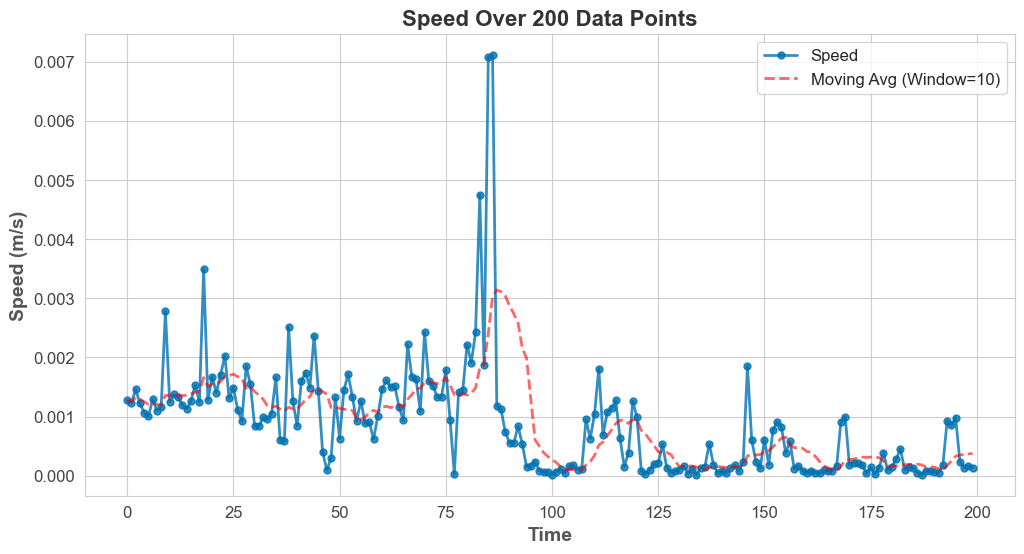

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Create the figure and plot
plt.figure(figsize=(12, 6))
plt.plot(testdf['speed'], marker='o', linestyle='-', color='#0072B2', markersize=5, linewidth=2, alpha=0.8, label="Speed")

# Add title and labels with enhanced formatting
plt.title('Speed Over 200 Data Points', fontsize=16, fontweight='bold', color='#333333')
plt.xlabel('Time', fontsize=14, fontweight='bold', color='#555555')
plt.ylabel('Speed (m/s)', fontsize=14, fontweight='bold', color='#555555')

# Improve tick formatting
plt.xticks(fontsize=12, color='#444444')
plt.yticks(fontsize=12, color='#444444')

# Add a smooth trend line using a moving average
window_size = 10 
testdf['speed_smooth'] = testdf['speed'].rolling(window=window_size, min_periods=1).mean()
plt.plot(testdf['speed_smooth'], color='red', linewidth=2, linestyle='--', alpha=0.6, label='Moving Avg (Window=10)')

# Add legend
plt.legend(fontsize=12, loc='upper right')

plt.savefig('Graphs/speed_over_time.png', dpi=400)
plt.show()



Do calculations again on new segment! 

In [16]:
updated_df = data_processing.calculations(updated_df, segment ='new_segment')

In [17]:
updated_df = data_processing.filter(updated_df)

In [ ]:
updated_df

lat         lon    alt  elapsed time                time  \
3        39.974320  116.399588  492.0  39816.056690 2009-01-03 01:21:38   
4        39.974365  116.399730  491.0  39816.056701 2009-01-03 01:21:39   
5        39.974391  116.399782  491.0  39816.056736 2009-01-03 01:21:42   
6        39.974426  116.399735  491.0  39816.056782 2009-01-03 01:21:46   
7        39.974458  116.399700  491.0  39816.056840 2009-01-03 01:21:51   
...            ...         ...    ...           ...                 ...   
4999995  39.971962  116.325348  951.4  39597.675509 2008-05-29 16:12:44   
4999996  39.971953  116.325402  951.4  39597.675532 2008-05-29 16:12:46   
4999997  39.971973  116.325405  951.4  39597.675556 2008-05-29 16:12:48   
4999998  39.971967  116.325437  951.4  39597.675579 2008-05-29 16:12:50   
4999999  39.971982  116.325470  951.4  39597.675602 2008-05-29 16:12:52   

                 trajectory  label  user  segment    index  new_segment  \
3        20090103012134.plt      0   135      1.0        4            2   
4        20090103012134.plt      0   135      1.0        5            2   
5        20090103012134.plt      0   135      1.0        6            2   
6        20090103012134.plt      0   135      1.0        7            2   
7        20090103012134.plt      0   135      1.0        8            2   
...                     ...    ...   ...      ...      ...          ...   
4999995  20080529155909.plt      0    78   6483.1  4999996        28044   
4999996  20080529155909.plt      0    78   6483.1  4999997        28044   
4999997  20080529155909.plt      0    78   6483.1  4999998        28044   
4999998  20080529155909.plt      0    78   6483.1  4999999        28044   
4999999  20080529155909.plt      0    78   6483.1  5000000        28044   

         distance     speed  time_diff  acceleration     bearing  \
3        0.005672  0.002836        2.0     -0.001670   77.547097   
4        0.013094  0.013094        1.0      0.010258   67.533389   
5        0.005291  0.001764        3.0     -0.003777   56.877188   
6        0.005584  0.001396        4.0     -0.000092  314.179106   
7        0.004643  0.000929        5.0     -0.000094  320.031126   
...           ...       ...        ...           ...         ...   
4999995  0.004315  0.002158        2.0      0.000115  121.019465   
4999996  0.004635  0.002317        2.0      0.000080  101.485971   
4999997  0.002243  0.001121        2.0     -0.000598    7.422744   
4999998  0.002794  0.001397        2.0      0.000138  105.464939   
4999999  0.003292  0.001646        2.0      0.000124   59.553823   

         heading_change     Vrate  angular_velocity  angular_acceleration  
3            210.275581  1.177637       -105.137790            -61.981946  
4             10.013708  0.783402        -10.013708             95.124082  
5             10.656201  6.424578         -3.552067              2.153880  
6            257.301918  0.263217         64.325480             16.969387  
7              5.852020  0.503513          1.170404            -12.631015  
...                 ...       ...               ...                   ...  
4999995       14.248975  0.107002          7.124488             -5.165315  
4999996       19.533494  0.068892         -9.766747             -8.445617  
4999997       94.063227  1.066619        -47.031614            -18.632433  
4999998       98.042195  0.197307         49.021098             48.026356  
4999999       45.911116  0.151173        -22.955558            -35.988328  

[4738590 rows x 20 columns]

Save the unlabelled dataset

In [ ]:
updated_df.to_pickle("updated_df_fifteen.pkl")